In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Data Preprocessing and Cleaning**

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/gdrive/MyDrive/Data Preprocessing Datasets/data.csv')

In [ ]:
# Data types of each column
data_types = data.dtypes

In [ ]:
# Check for missing values
missing_values = data.isnull().sum()

In [ ]:
# Summary statistics for numeric columns
summary_stats = data.describe()

In [ ]:
# Check for duplicate rows
duplicate_rows = data.duplicated().sum()

data_types, missing_values, summary_stats, duplicate_rows

(Unnamed: 0              int64
 Name                   object
 Affilation             object
 H-index                 int64
 Citations 2020          int64
 Total_citation          int64
 H-index_since_2016      int64
 Citation_since_2016     int64
 HomePage               object
 Area of Research       object
 Google_Scholar         object
 dtype: object,
 Unnamed: 0             0
 Name                   0
 Affilation             0
 H-index                0
 Citations 2020         0
 Total_citation         0
 H-index_since_2016     0
 Citation_since_2016    0
 HomePage               0
 Area of Research       2
 Google_Scholar         0
 dtype: int64,
        Unnamed: 0     H-index  Citations 2020  Total_citation  \
 count  104.000000  104.000000      104.000000      104.000000   
 mean    51.500000   75.548077     4484.711538    31649.365385   
 std     30.166206   33.236101     2874.355109    28244.294517   
 min      0.000000    2.000000       14.000000       27.000000   
 25%     25.

In [ ]:
# Handle missing values in "Area of Research"
data['Area of Research'].fillna('Not Specified', inplace=True)

# Drop the "Unnamed: 0" column
data.drop(columns=['Unnamed: 0'], inplace=True)

**Clustering, Anomaly Detection, and Data Preparation**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extracting numeric columns for clustering
numeric_data = data[['H-index', 'Citations 2020', 'Total_citation', 'H-index_since_2016', 'Citation_since_2016']]

In [ ]:
# Scaling the numeric data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

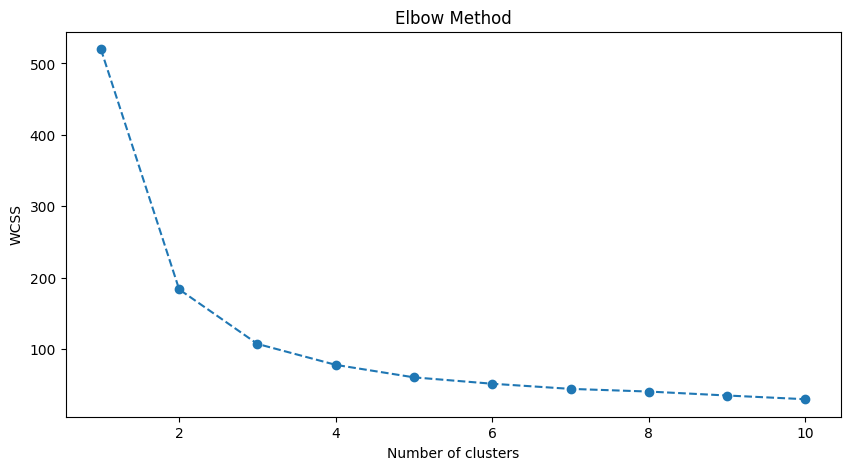

In [ ]:
# Determining the optimal number of clusters using the Elbow method
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow method graph
plt.figure(figsize=(10,5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [ ]:
# Apply KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Detect anomalies
# We'll consider data points that are beyond a certain threshold from their cluster centroids as anomalies
threshold = 2.5
distance_to_centroid = [np.linalg.norm(a-b) for a, b in zip(scaled_data, kmeans.cluster_centers_[kmeans.labels_])]
anomalies = np.where(np.array(distance_to_centroid) > threshold)[0]

In [ ]:
# Add a column to indicate if the row is an anomaly
data['Anomaly'] = 0
data.loc[anomalies, 'Anomaly'] = 1

In [ ]:
# Display the number of anomalies detected and the first few rows with cluster labels and anomaly column
num_anomalies = len(anomalies)
num_anomalies, data.head()

(1,
                                                 Name  \
 0  U Rajendra Acharya (SCI Highly Cited Researche...   
 1                                  IAN  F.  AKYILDIZ   
 2                                    Ibrahim Aljarah   
 3                                    Jeffrey Andrews   
 4                                       Bennis Mehdi   
 
                                           Affilation  H-index  Citations 2020  \
 0  Ngee Ann,  Singapore University of Social Scie...      108            8767   
 1                                   Truva Inc. , USA      131            6707   
 2          Associate Professor, University of Jordan       42            2260   
 3  Cockrell Family Endowed Chair in Engineering, ...      104            4659   
 4  Full Professor, IEEE Fellow, Head of ICON, Uni...       64            5562   
 
    Total_citation  H-index_since_2016  Citation_since_2016  \
 0           46452                  97                36679   
 1          131149              

In [ ]:
# Drop columns that may not provide predictive power
data_ml = data.drop(columns=['Name', 'HomePage', 'Google_Scholar'])

# One-hot encode the categorical columns "Affilation" and "Area of Research"
data_encoded = pd.get_dummies(data_ml, columns=['Affilation', 'Area of Research'], drop_first=True)

In [ ]:
from sklearn.model_selection import train_test_split

# Define the features (X) and target (y)
X = data_encoded.drop(columns=['Anomaly'])
y = data_encoded['Anomaly']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Building Machine Learning Models with AutoML**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score

# Define the classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

In [ ]:
# Train and evaluate the classifiers
results = {}
for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    results[name] = {'Accuracy': accuracy, 'F1 Score': f1}

In [ ]:
results_df = pd.DataFrame(results).T
results_df

,Accuracy,F1 Score
Logistic Regression,1.0,1.0
Random Forest,1.0,1.0
Gradient Boosting,1.0,1.0


In [ ]:
from sklearn.ensemble import VotingClassifier

# Create a majority-voting ensemble classifier
ensemble_clf = VotingClassifier(estimators=[
    ('Logistic Regression', classifiers['Logistic Regression']),
    ('Random Forest', classifiers['Random Forest']),
    ('Gradient Boosting', classifiers['Gradient Boosting'])
], voting='hard')

In [ ]:
# Train the ensemble classifier
ensemble_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('Random Forest',
                              RandomForestClassifier(random_state=42)),
                             ('Gradient Boosting',
                              GradientBoostingClassifier(random_state=42))])

In [ ]:
# Predict on the test set
y_pred_ensemble = ensemble_clf.predict(X_test)

# Evaluate the ensemble classifier
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble, average='weighted')

accuracy_ensemble, f1_ensemble

(1.0, 1.0)